In [2]:
# web crape to get data of Washington's postal codes, their corresponding cites and addresses.
import requests
import pandas as pd

link = "https://www.geonames.org/postal-codes/US/WA/washington.html"
f = requests.get(link).text

# utilize BeautifulSoup to scrape the web page
from bs4 import BeautifulSoup
soup = BeautifulSoup(f,'lxml')

In [3]:
soup

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd ">
<html>
<head>
<title>Postal Codes Washington, United States</title>
<link href="https://www.geonames.org/opensearch-description.xml" rel="search" title="geonames" type="application/opensearchdescription+xml"/>
<link href="/geonames.ico" rel="shortcut icon"/>
<link href="/geonames.css" rel="StyleSheet" type="text/css"/>
</head>
<body>
<table cellpadding="0" cellspacing="0" id="topmenutable"><tr>
<td class="topmenu"> <a href="/" title="GeoName Home"> GeoNames Home</a> | <a href="/postal-codes/" title="Postal Codes">Postal Codes</a> | <a href="/export/" title="Database Dump and Webservice API">Download / Webservice</a> | <a href="/about.html" title="About GeoNames">About</a> </td>
<td class="topsearch">
<form action="/servlet/geonames" class="topsearch" method="get" name="searchForm">

      search <input class="topmenu" name="q" size="20" type="text" value=""/>
<input name="srv" type="

In [4]:
My_table = soup.find('table',{'class':"restable"})

In [117]:
# get postal codes, corresponding cities and geo locations
PostalCode = []
city = []
location = []

for row in My_table.findAll('tr'):
    td = row.findAll('td')
    if row.a is None and len(td)>1:
        city.append(td[1].text)
        PostalCode.append(td[2].text)
    if row.a is not None:
        location.append(row.a.text)

In [119]:
# get latitude and longitude
latitude = []
longitude = []
for ll in location:
    latitude.append(float(ll.split('/')[0]))
    longitude.append(float(ll.split('/')[1]))

In [120]:
# build a dataframe with postal codes, corresponding cities, latitude, and longitude
df = pd.DataFrame()
df['Postal Code'] = PostalCode
df['City'] = city
df['Latitude'] = latitude
df['Longitude'] = longitude
df.head()

Postal Code         City  Latitude  Longitude
0       98104      Seattle    47.604   -122.326
1       98101      Seattle    47.611   -122.330
2       98001       Auburn    47.310   -122.265
3       98002       Auburn    47.305   -122.207
4       98003  Federal Way    47.320   -122.312

In [51]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# find latitude and longitude of Seattle, WA
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Seattle, Washington'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude 
longitude = location.longitude
print(latitude, longitude)

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

47.6038321 -122.3300624


In [163]:
CLIENT_ID = '0XKX2RX2NRRD0FADR5PGUQ1YDX1MWT2WVCWQ5F5ZNMZVL4HC' # your Foursquare ID
CLIENT_SECRET = 'ZA50HUYWOWEMAMZXRMPIRAJJYNH14OMYGLKEBUKPP2S4GMMM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
radius = 500

address = 'Seattle, Washington'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude 
longitude = location.longitude
print(latitude, longitude)

47.6038321 -122.3300624


In [164]:
# create a map using seattle's latitude and longitude values
map = folium.Map(location=[47.6038321, -122.3300624], zoom_start=10)
map

In [121]:
# add markers to map
for lat, lng, city, code in zip(df['Latitude'], df['Longitude'], df['City'], df['Postal Code']):
    label = '{}, {}'.format(city, code)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
map

In [127]:
CLIENT_ID = '0XKX2RX2NRRD0FADR5PGUQ1YDX1MWT2WVCWQ5F5ZNMZVL4HC' 
CLIENT_SECRET = 'ZA50HUYWOWEMAMZXRMPIRAJJYNH14OMYGLKEBUKPP2S4GMMM' 
VERSION = '20180604'
LIMIT = 100

In [128]:
# create a function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [129]:
# get nearby venues of all cities
venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
print(venues.shape)
venues.head()

Seattle
Seattle
Auburn
Auburn
Federal Way
Bellevue
Bellevue
Bellevue
Bellevue
Bellevue
Bothell
Edmonds
Edmonds
Issaquah
Kent
Kent
Kirkland
Lynnwood
Medina
Mercer Island
Pacific
Redmond
Renton
Renton
Woodinville
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Seattle
Everett
Everett
Everett
Everett
Arlington
Bellingham
Bellingham
Freeland
Monroe
Snohomish
Stanwood
Bremerton
Kingston
Port Angeles
Poulsbo
Puyallup
Sumner
Aberdeen
Shelton
Kelso
Vancouver
East Wenatchee
Moses Lake
Yakima
Yakima
Spokane
Spokane
Connell
Kennewick
Mesa
Richland
Walla Walla
Bellevue
Black Diamond
Bothell
Burton
Carnation
Bellevue
Duvall
Bothell
Enumclaw
Federal Way
Fall City
Hobart
Kenmore
Issaquah
Kirkland
Kent
Lynnwood
Maple Valley
Bothell
Kent
Mountlake Terrace
North Bend
Lynnwood
Preston
Ravensdale
Redmond
Renton
Renton
Renton
Rollingbay
Seahurst
Federal Way
Kent
Snoqualmie
Snoqual

City  City Latitude  City Longitude  \
0  Seattle         47.604        -122.326   
1  Seattle         47.604        -122.326   
2  Seattle         47.604        -122.326   
3  Seattle         47.604        -122.326   
4  Seattle         47.604        -122.326   

                                               Venue  Venue Latitude  \
0                                Columbia Tower Club       47.604507   
1                                    Frye Art Museum       47.607051   
2                                         Juicy Cafe       47.604329   
3  Columbia Center Observation Deck (Sky View Obs...       47.604595   
4                                      Biscuit B*tch       47.603237   

   Venue Longitude  Venue Category  
0      -122.330484     Social Club  
1      -122.324326      Art Museum  
2      -122.330958            Café  
3      -122.330816  Scenic Lookout  
4      -122.332010  Breakfast Spot

In [131]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 287 uniques categories.


In [132]:
venues.groupby('City').count()

City Latitude  City Longitude  Venue  Venue Latitude  \
City                                                                      
Aberdeen                       1               1      1               1   
Anacortes                      1               1      1               1   
Arlington                      1               1      1               1   
Auburn                        34              34     34              34   
Bainbridge Island              1               1      1               1   
...                          ...             ...    ...             ...   
Sumner                         4               4      4               4   
Vancouver                      6               6      6               6   
Vashon                         5               5      5               5   
Woodinville                    1               1      1               1   
Yakima                        34              34     34              34   

                   Venue Longitude  Venue Category  
City                                                
Aberdeen                         1               1  
Anacortes                        1               1  
Arlington                        1               1  
Auburn                          34              34  
Bainbridge Island                1               1  
...                            ...             ...  
Sumner                           4               4  
Vancouver                        6               6  
Vashon                           5               5  
Woodinville                      1               1  
Yakima                          34              34  

[86 rows x 6 columns]

In [133]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
onehot['City'] = venues['City'] 

onehot.shape

(3119, 288)

In [134]:
#group rows by city and by taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby('City').mean().reset_index()
grouped

City  ATM  Accessories Store  Adult Boutique  Airport  \
0            Aberdeen  0.0                0.0        0.000000      0.0   
1           Anacortes  0.0                0.0        0.000000      0.0   
2           Arlington  0.0                0.0        0.000000      0.0   
3              Auburn  0.0                0.0        0.029412      0.0   
4   Bainbridge Island  0.0                0.0        0.000000      0.0   
..                ...  ...                ...             ...      ...   
81             Sumner  0.0                0.0        0.000000      0.0   
82          Vancouver  0.0                0.0        0.000000      0.0   
83             Vashon  0.0                0.0        0.000000      0.0   
84        Woodinville  0.0                0.0        0.000000      0.0   
85             Yakima  0.0                0.0        0.000000      0.0   

    Airport Lounge  American Restaurant  Animal Shelter  Arcade  Art Gallery  \
0              0.0             0.000000             0.0     0.0          0.0   
1              0.0             0.000000             0.0     0.0          0.0   
2              0.0             0.000000             0.0     0.0          0.0   
3              0.0             0.029412             0.0     0.0          0.0   
4              0.0             0.000000             0.0     0.0          0.0   
..             ...                  ...             ...     ...          ...   
81             0.0             0.000000             0.0     0.0          0.0   
82             0.0             0.000000             0.0     0.0          0.0   
83             0.0             0.000000             0.0     0.0          0.0   
84             0.0             0.000000             0.0     0.0          0.0   
85             0.0             0.058824             0.0     0.0          0.0   

    ...  Water Park  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  \
0   ...         0.0                 0.0         0.0  0.000000        0.0   
1   ...         0.0                 0.0         0.0  0.000000        0.0   
2   ...         0.0                 0.0         0.0  0.000000        0.0   
3   ...         0.0                 0.0         0.0  0.000000        0.0   
4   ...         0.0                 0.0         0.0  0.000000        0.0   
..  ...         ...                 ...         ...       ...        ...   
81  ...         0.0                 0.0         0.0  0.000000        0.0   
82  ...         0.0                 0.0         0.0  0.000000        0.0   
83  ...         0.0                 0.0         0.0  0.000000        0.0   
84  ...         0.0                 0.0         0.0  0.000000        0.0   
85  ...         0.0                 0.0         0.0  0.029412        0.0   

    Winery  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0      0.0          0.0            0.0          0.0          0.0  
1      0.0          0.0            0.0          0.0          0.0  
2      0.0          0.0            0.0          0.0          0.0  
3      0.0          0.0            0.0          0.0          0.0  
4      0.0          0.0            0.0          0.0          0.0  
..     ...          ...            ...          ...          ...  
81     0.0          0.0            0.0          0.0          0.0  
82     0.0          0.0            0.0          0.0          0.0  
83     0.0          0.0            0.0          0.0          0.0  
84     0.0          0.0            0.0          0.0          0.0  
85     0.0          0.0            0.0          0.0          0.0  

[86 rows x 288 columns]

In [135]:
# print each city along with the top 5 most common venues¶
num_top_venues = 5

for city in grouped['City']:
    print("----"+city+"----")
    temp = grouped[grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aberdeen----
                           venue  freq
0               Business Service   1.0
1                            ATM   0.0
2  Paper / Office Supplies Store   0.0
3                           Pier   0.0
4                       Pharmacy   0.0


----Anacortes----
          venue  freq
0  Home Service   1.0
1  Noodle House   0.0
2   Pizza Place   0.0
3          Pier   0.0
4      Pharmacy   0.0


----Arlington----
                           venue  freq
0                  Garden Center   1.0
1                            ATM   0.0
2  Paper / Office Supplies Store   0.0
3                           Pier   0.0
4                       Pharmacy   0.0


----Auburn----
           venue  freq
0   Home Service  0.09
1    Coffee Shop  0.09
2           Bank  0.06
3     Restaurant  0.06
4  Grocery Store  0.06


----Bainbridge Island----
         venue  freq
0         Tree   1.0
1     Platform   0.0
2  Pizza Place   0.0
3         Pier   0.0
4     Pharmacy   0.0


----Bellevue----
               

In [136]:
# create a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [137]:
# create a new dataframe and display the top 10 venues for each city
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = grouped['City']

for ind in np.arange(grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

City 1st Most Common Venue 2nd Most Common Venue  \
0           Aberdeen      Business Service           Zoo Exhibit   
1          Anacortes          Home Service                  Food   
2          Arlington         Garden Center           Zoo Exhibit   
3             Auburn          Home Service           Coffee Shop   
4  Bainbridge Island                  Tree           Zoo Exhibit   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0   Fried Chicken Joint            Food Court            Food Truck   
1     Food & Drink Shop            Food Court            Food Truck   
2   Fried Chicken Joint            Food Court            Food Truck   
3                  Café            Restaurant         Grocery Store   
4                  Food            Food Court            Food Truck   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Football Stadium                Forest              Fountain   
1      Football Stadium                Forest              Fountain   
2      Football Stadium                Forest              Fountain   
3                  Bank    Mexican Restaurant               Theater   
4      Football Stadium                Forest              Fountain   

        9th Most Common Venue 10th Most Common Venue  
0           French Restaurant     Frozen Yogurt Shop  
1           French Restaurant            Zoo Exhibit  
2           French Restaurant     Frozen Yogurt Shop  
3  Construction & Landscaping                   Park  
4           French Restaurant    Fried Chicken Joint

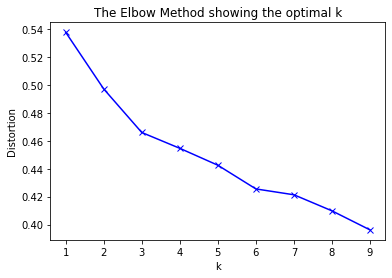

In [211]:
# use k-means to cluster the neighborhood into the optimal number of clusters
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# find the optimal number of clusters by Elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(grouped_clustering)
    kmeanModel.fit(grouped_clustering)
    distortions.append(sum(np.min(cdist(grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [212]:
# set number of clusters
kclusters = 9

grouped_clustering = grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 1, 1, 1, 1, 1, 3, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       0, 1, 7, 1, 1, 7, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1,
       1, 0, 1, 1, 4, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1],
      dtype=int32)

In [213]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
cities_venues_sorted['Cluster Labels'] = kmeans.labels_

merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(cities_venues_sorted.set_index('City'), on='City')

# remove all rows with NaNs in column 'Cluster Labels'
merged = merged.dropna(subset=['Cluster Labels'])

# convert values to int
merged['Cluster Labels'] = merged['Cluster Labels'].astype(int)

merged.head()

Postal Code         City  Latitude  Longitude  Cluster Labels  \
0       98104      Seattle    47.604   -122.326               1   
1       98101      Seattle    47.611   -122.330               1   
2       98001       Auburn    47.310   -122.265               1   
3       98002       Auburn    47.305   -122.207               1   
4       98003  Federal Way    47.320   -122.312               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop                 Hotel                  Café   
1           Coffee Shop                 Hotel                  Café   
2          Home Service           Coffee Shop                  Café   
3          Home Service           Coffee Shop                  Café   
4     Korean Restaurant        Ice Cream Shop       Thai Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Italian Restaurant           Pizza Place        Sandwich Place   
1    Italian Restaurant           Pizza Place        Sandwich Place   
2            Restaurant         Grocery Store                  Bank   
3            Restaurant         Grocery Store                  Bank   
4             Pet Store         Grocery Store                  Café   

  7th Most Common Venue 8th Most Common Venue       9th Most Common Venue  \
0                   Gym          Cocktail Bar                Burger Joint   
1                   Gym          Cocktail Bar                Burger Joint   
2    Mexican Restaurant               Theater  Construction & Landscaping   
3    Mexican Restaurant               Theater  Construction & Landscaping   
4        Discount Store                Bakery           Convenience Store   

  10th Most Common Venue  
0     Seafood Restaurant  
1     Seafood Restaurant  
2                   Park  
3                   Park  
4     Salon / Barbershop

In [214]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['City'], merged['Cluster Labels']):
    label = folium.Popup(poi + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map)
       
map

In [216]:
#examine each cluster

# cluster 0(red)
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
19        98040          Home Service                Lawyer   
63        98371          Home Service       Paintball Field   
86        98019          Home Service                  Food   
91        98025          Home Service                Market   
149       98221          Home Service                  Food   
178       98260          Home Service                  Food   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19              Locksmith     French Restaurant     Food & Drink Shop   
63                   Park                  Food            Food Court   
86      Food & Drink Shop            Food Court            Food Truck   
91      French Restaurant     Food & Drink Shop            Food Court   
149     Food & Drink Shop            Food Court            Food Truck   
178     Food & Drink Shop            Food Court            Food Truck   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
19             Food Court            Food Truck      Football Stadium   
63             Food Truck      Football Stadium                Forest   
86       Football Stadium                Forest              Fountain   
91             Food Truck      Football Stadium                Forest   
149      Football Stadium                Forest              Fountain   
178      Football Stadium                Forest              Fountain   

    9th Most Common Venue 10th Most Common Venue  
19                 Forest               Fountain  
63               Fountain            Zoo Exhibit  
86      French Restaurant            Zoo Exhibit  
91               Fountain    Fried Chicken Joint  
149     French Restaurant            Zoo Exhibit  
178     French Restaurant            Zoo Exhibit

In [217]:
# cluster 1(purple)
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
0         98104           Coffee Shop                 Hotel   
1         98101           Coffee Shop                 Hotel   
2         98001          Home Service           Coffee Shop   
3         98002          Home Service           Coffee Shop   
4         98003     Korean Restaurant        Ice Cream Shop   
..          ...                   ...                   ...   
192       98280                  Café         Boat or Ferry   
193       98281        Lighting Store         Garden Center   
195       98284                   Bar      Business Service   
197       98287        Breakfast Spot             Pet Store   
199       98291          Home Service       Bed & Breakfast   

          3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                          Café    Italian Restaurant           Pizza Place   
1                          Café    Italian Restaurant           Pizza Place   
2                          Café            Restaurant         Grocery Store   
3                          Café            Restaurant         Grocery Store   
4               Thai Restaurant             Pet Store         Grocery Store   
..                          ...                   ...                   ...   
192               Grocery Store            Astrologer                Bistro   
193         Fried Chicken Joint            Food Court            Food Truck   
195                 Video Store           Zoo Exhibit   Fried Chicken Joint   
197                    Dive Bar            Food Truck      Football Stadium   
199  Construction & Landscaping           Zoo Exhibit     French Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0          Sandwich Place                   Gym          Cocktail Bar   
1          Sandwich Place                   Gym          Cocktail Bar   
2                    Bank    Mexican Restaurant               Theater   
3                    Bank    Mexican Restaurant               Theater   
4                    Café        Discount Store                Bakery   
..                    ...                   ...                   ...   
192       Harbor / Marina                   Bar             Gift Shop   
193      Football Stadium                Forest              Fountain   
195            Food Truck      Football Stadium                Forest   
197                Forest              Fountain     French Restaurant   
199            Food Truck      Football Stadium                Forest   

          9th Most Common Venue 10th Most Common Venue  
0                  Burger Joint     Seafood Restaurant  
1                  Burger Joint     Seafood Restaurant  
2    Construction & Landscaping                   Park  
3    Construction & Landscaping                   Park  
4             Convenience Store     Salon / Barbershop  
..                          ...                    ...  
192                 Fabric Shop               Fountain  
193           French Restaurant            Zoo Exhibit  
195                    Fountain      French Restaurant  
197         Fried Chicken Joint     Frozen Yogurt Shop  
199                    Fountain    Fried Chicken Joint  

[159 rows x 11 columns]

In [218]:
# cluster 2(dark blue)
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
24        98072      Business Service           Zoo Exhibit   
56        98272      Business Service           Zoo Exhibit   
65        98520      Business Service           Zoo Exhibit   
67        98626                Garden      Business Service   
172       98252      Business Service           Zoo Exhibit   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
24    Fried Chicken Joint            Food Court            Food Truck   
56    Fried Chicken Joint            Food Court            Food Truck   
65    Fried Chicken Joint            Food Court            Food Truck   
67            Zoo Exhibit   Fried Chicken Joint            Food Court   
172   Fried Chicken Joint            Food Court            Food Truck   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
24       Football Stadium                Forest              Fountain   
56       Football Stadium                Forest              Fountain   
65       Football Stadium                Forest              Fountain   
67             Food Truck      Football Stadium                Forest   
172      Football Stadium                Forest              Fountain   

    9th Most Common Venue 10th Most Common Venue  
24      French Restaurant     Frozen Yogurt Shop  
56      French Restaurant     Frozen Yogurt Shop  
65      French Restaurant     Frozen Yogurt Shop  
67               Fountain      French Restaurant  
172     French Restaurant     Frozen Yogurt Shop

In [219]:
# cluster 3(light blue)
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
121       98110                  Tree           Zoo Exhibit   
166       98244                  Tree      Business Service   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
121                  Food            Food Court            Food Truck   
166           Zoo Exhibit   Fried Chicken Joint            Food Court   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
121      Football Stadium                Forest              Fountain   
166            Food Truck      Football Stadium                Forest   

    9th Most Common Venue 10th Most Common Venue  
121     French Restaurant    Fried Chicken Joint  
166              Fountain      French Restaurant

In [220]:
# cluster 4(cyan)
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
78       99352                   Gym           Zoo Exhibit   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
78   Fried Chicken Joint            Food Court            Food Truck   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
78      Football Stadium                Forest              Fountain   

   9th Most Common Venue 10th Most Common Venue  
78     French Restaurant     Frozen Yogurt Shop

In [221]:
# cluster 5(light green)
merged.loc[merged['Cluster Labels'] == 5, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
83        98013       Harbor / Marina           Coffee Shop   
196       98286       Harbor / Marina           Golf Course   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
83          Grocery Store            Food Court            Food Truck   
196            Food Court            Food Truck      Football Stadium   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
83       Football Stadium                Forest              Fountain   
196                Forest              Fountain     French Restaurant   

    9th Most Common Venue 10th Most Common Venue  
83      French Restaurant    Fried Chicken Joint  
196   Fried Chicken Joint            Zoo Exhibit

In [222]:
# cluster 6(light yellow)
merged.loc[merged['Cluster Labels'] == 6, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
20       98047           Candy Store        Discount Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
20            Food Court            Food Truck      Football Stadium   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
20                Forest              Fountain     French Restaurant   

   9th Most Common Venue 10th Most Common Venue  
20   Fried Chicken Joint            Zoo Exhibit

In [223]:
# cluster 7(yellow)
merged.loc[merged['Cluster Labels'] == 7, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
180       98263   American Restaurant                  Food   
183       98267   American Restaurant           Zoo Exhibit   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
180           Zoo Exhibit   Fried Chicken Joint            Food Court   
183   Fried Chicken Joint            Food Court            Food Truck   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
180            Food Truck      Football Stadium                Forest   
183      Football Stadium                Forest              Fountain   

    9th Most Common Venue 10th Most Common Venue  
180              Fountain      French Restaurant  
183     French Restaurant     Frozen Yogurt Shop

In [224]:
# cluster 8(light orange)
merged.loc[merged['Cluster Labels'] == 8, merged.columns[[0] + list(range(5, merged.shape[1]))]]

Postal Code  1st Most Common Venue 2nd Most Common Venue  \
84       98014  Outdoors & Recreation           Karaoke Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
84            Food Court            Food Truck      Football Stadium   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
84                Forest              Fountain     French Restaurant   

   9th Most Common Venue 10th Most Common Venue  
84   Fried Chicken Joint            Zoo Exhibit

In [179]:
# get venues in Seattle
seattle_venues = venues[venues['City'] == 'Seattle']
seattle_venues

City  City Latitude  City Longitude  \
0     Seattle         47.604        -122.326   
1     Seattle         47.604        -122.326   
2     Seattle         47.604        -122.326   
3     Seattle         47.604        -122.326   
4     Seattle         47.604        -122.326   
...       ...            ...             ...   
2829  Seattle         47.606        -122.332   
2830  Seattle         47.606        -122.332   
2831  Seattle         47.606        -122.332   
2832  Seattle         47.606        -122.332   
2833  Seattle         47.606        -122.332   

                                                  Venue  Venue Latitude  \
0                                   Columbia Tower Club       47.604507   
1                                       Frye Art Museum       47.607051   
2                                            Juicy Cafe       47.604329   
3     Columbia Center Observation Deck (Sky View Obs...       47.604595   
4                                         Biscuit B*tch       47.603237   
...                                                 ...             ...   
2829                                            Cortina       47.610378   
2830                                Flame Catering Cafe       47.602212   
2831                                     Pioneer Square       47.601977   
2832                            Merchants Cafe & Saloon       47.601809   
2833                                     The Halal Guys       47.601824   

      Venue Longitude      Venue Category  
0         -122.330484         Social Club  
1         -122.324326          Art Museum  
2         -122.330958                Café  
3         -122.330816      Scenic Lookout  
4         -122.332010      Breakfast Spot  
...               ...                 ...  
2829      -122.332707  Italian Restaurant  
2830      -122.330820                Café  
2831      -122.333896                Park  
2832      -122.333435        Burger Joint  
2833      -122.333584    Halal Restaurant  

[1721 rows x 7 columns]

In [180]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 204 uniques categories.


In [191]:
# one hot encoding
onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
onehot['City'] = seattle_venues['City'] 

onehot.shape

(1721, 205)

In [192]:
onehot.head()

ATM  Accessories Store  Airport Lounge  American Restaurant  Art Gallery  \
0    0                  0               0                    0            0   
1    0                  0               0                    0            0   
2    0                  0               0                    0            0   
3    0                  0               0                    0            0   
4    0                  0               0                    0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Automotive Shop  \
0           0                    0                 0                0   
1           1                    0                 0                0   
2           0                    0                 0                0   
3           0                    0                 0                0   
4           0                    0                 0                0   

   BBQ Joint  ...  Video Store  Vietnamese Restaurant  Warehouse Store  \
0          0  ...            0                      0                0   
1          0  ...            0                      0                0   
2          0  ...            0                      0                0   
3          0  ...            0                      0                0   
4          0  ...            0                      0                0   

   Whisky Bar  Wine Bar  Wine Shop  Women's Store  Yoga Studio  Zoo Exhibit  \
0           0         0          0              0            0            0   
1           0         0          0              0            0            0   
2           0         0          0              0            0            0   
3           0         0          0              0            0            0   
4           0         0          0              0            0            0   

      City  
0  Seattle  
1  Seattle  
2  Seattle  
3  Seattle  
4  Seattle  

[5 rows x 205 columns]

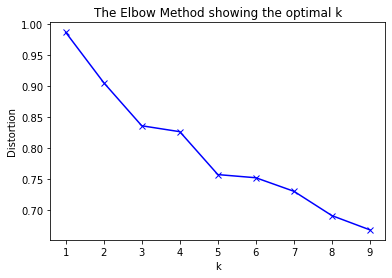

In [226]:
# find the optimal number of clusters by Elbow method
distortions = []
cluster = onehot.drop('City', 1)
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cluster)
    kmeanModel.fit(cluster)
    distortions.append(sum(np.min(cdist(cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [227]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 7, ..., 0, 0, 0], dtype=int32)

In [228]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
seattle_venues['Cluster Labels'] = kmeans.labels_

# remove all rows with NaNs in column 'Cluster Labels'
seattle_venues = seattle_venues.dropna(subset=['Cluster Labels'])

# convert values to int
seattle_venues['Cluster Labels'] = seattle_venues['Cluster Labels'].astype(int)

seattle_venues.head()

City  City Latitude  City Longitude  \
0  Seattle         47.604        -122.326   
1  Seattle         47.604        -122.326   
2  Seattle         47.604        -122.326   
3  Seattle         47.604        -122.326   
4  Seattle         47.604        -122.326   

                                               Venue  Venue Latitude  \
0                                Columbia Tower Club       47.604507   
1                                    Frye Art Museum       47.607051   
2                                         Juicy Cafe       47.604329   
3  Columbia Center Observation Deck (Sky View Obs...       47.604595   
4                                      Biscuit B*tch       47.603237   

   Venue Longitude  Venue Category  Cluster Labels  
0      -122.330484     Social Club               0  
1      -122.324326      Art Museum               0  
2      -122.330958            Café               7  
3      -122.330816  Scenic Lookout               0  
4      -122.332010  Breakfast Spot               0

In [251]:
# create a second map using seattle's latitude and longitude values
map2 = folium.Map(location=[47.6038321, -122.3300624], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cat, cluster in zip(seattle_venues['Venue Latitude'], seattle_venues['Venue Longitude'], seattle_venues['Venue'], seattle_venues['Venue Category'], seattle_venues['Cluster Labels']):
    label = folium.Popup(name + ',' + cat + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map2)
       
map2

In [230]:
# examine each cluster

# cluster 0(red)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 0, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  \
0                                   Columbia Tower Club       47.604507   
1                                       Frye Art Museum       47.607051   
3     Columbia Center Observation Deck (Sky View Obs...       47.604595   
4                                         Biscuit B*tch       47.603237   
5                                           Tsukushinbo       47.599963   
...                                                 ...             ...   
2826                                        Collins Pub       47.602081   
2828                                      Sprout Salads       47.602018   
2831                                     Pioneer Square       47.601977   
2832                            Merchants Cafe & Saloon       47.601809   
2833                                     The Halal Guys       47.601824   

      Venue Longitude       Venue Category  
0         -122.330484          Social Club  
1         -122.324326           Art Museum  
3         -122.330816       Scenic Lookout  
4         -122.332010       Breakfast Spot  
5         -122.326878  Japanese Restaurant  
...               ...                  ...  
2826      -122.332426                  Pub  
2828      -122.332331          Salad Place  
2831      -122.333896                 Park  
2832      -122.333435         Burger Joint  
2833      -122.333584     Halal Restaurant  

[1183 rows x 4 columns]

In [231]:
# cluster 1(purple)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 1, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude  \
7                   Il Corvo       47.602522      -122.331952   
51                     Primo       47.608922      -122.329370   
55                   Cortina       47.610378      -122.332707   
92          Tulio Ristorante       47.607460      -122.332410   
93    Ristorante Machiavelli       47.615092      -122.328125   
...                      ...             ...              ...   
2753                 Cortina       47.610378      -122.332707   
2764        Tulio Ristorante       47.607460      -122.332410   
2783                Il Corvo       47.602522      -122.331952   
2809                   Primo       47.608922      -122.329370   
2829                 Cortina       47.610378      -122.332707   

          Venue Category  
7     Italian Restaurant  
51    Italian Restaurant  
55    Italian Restaurant  
92    Italian Restaurant  
93    Italian Restaurant  
...                  ...  
2753  Italian Restaurant  
2764  Italian Restaurant  
2783  Italian Restaurant  
2809  Italian Restaurant  
2829  Italian Restaurant  

[67 rows x 4 columns]

In [232]:
# cluster 2(light blue)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 2, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  \
83                      Ruth's Chris Steak House       47.612813   
671                       The Grill From Ipanema       47.613482   
676                                    El Gaucho       47.614701   
1719                          Metropolitan Grill       47.604617   
1781  The Brooklyn Seafood, Steak & Oyster House       47.607138   
1795                          Metropolitan Grill       47.604617   
1857  The Brooklyn Seafood, Steak & Oyster House       47.607138   
1875                          Metropolitan Grill       47.604617   
1937  The Brooklyn Seafood, Steak & Oyster House       47.607138   
1951                          Metropolitan Grill       47.604617   
2013  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2027                          Metropolitan Grill       47.604617   
2089  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2118                          Metropolitan Grill       47.604617   
2180  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2194                          Metropolitan Grill       47.604617   
2256  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2283                          Metropolitan Grill       47.604617   
2345  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2369                          Metropolitan Grill       47.604617   
2431  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2445                          Metropolitan Grill       47.604617   
2507  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2527                          Metropolitan Grill       47.604617   
2589  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2609                          Metropolitan Grill       47.604617   
2671  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2685                          Metropolitan Grill       47.604617   
2747  The Brooklyn Seafood, Steak & Oyster House       47.607138   
2761                          Metropolitan Grill       47.604617   
2823  The Brooklyn Seafood, Steak & Oyster House       47.607138   

      Venue Longitude Venue Category  
83        -122.333190     Steakhouse  
671       -122.347845     Steakhouse  
676       -122.349265     Steakhouse  
1719      -122.334280     Steakhouse  
1781      -122.336892     Steakhouse  
1795      -122.334280     Steakhouse  
1857      -122.336892     Steakhouse  
1875      -122.334280     Steakhouse  
1937      -122.336892     Steakhouse  
1951      -122.334280     Steakhouse  
2013      -122.336892     Steakhouse  
2027      -122.334280     Steakhouse  
2089      -122.336892     Steakhouse  
2118      -122.334280     Steakhouse  
2180      -122.336892     Steakhouse  
2194      -122.334280     Steakhouse  
2256      -122.336892     Steakhouse  
2283      -122.334280     Steakhouse  
2345      -122.336892     Steakhouse  
2369      -122.334280     Steakhouse  
2431      -122.336892     Steakhouse  
2445      -122.334280     Steakhouse  
2507      -122.336892     Steakhouse  
2527      -122.334280     Steakhouse  
2589      -122.336892     Steakhouse  
2609      -122.334280     Steakhouse  
2671      -122.336892     Steakhouse  
2685      -122.334280     Steakhouse  
2747      -122.336892     Steakhouse  
2761      -122.334280     Steakhouse  
2823      -122.336892     Steakhouse

In [233]:
# cluster 3(dark blue)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 3, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude Venue Category
17             Vito's       47.608195      -122.327409         Lounge
76             Vito's       47.608195      -122.327409         Lounge
659              List       47.613224      -122.346186         Lounge
716   Sarajevo Lounge       47.614174      -122.347631         Lounge
718       Screwdriver       47.613826      -122.347238         Lounge
1772           Vito's       47.608195      -122.327409         Lounge
1848           Vito's       47.608195      -122.327409         Lounge
1928           Vito's       47.608195      -122.327409         Lounge
2004           Vito's       47.608195      -122.327409         Lounge
2080           Vito's       47.608195      -122.327409         Lounge
2171           Vito's       47.608195      -122.327409         Lounge
2247           Vito's       47.608195      -122.327409         Lounge
2336           Vito's       47.608195      -122.327409         Lounge
2422           Vito's       47.608195      -122.327409         Lounge
2498           Vito's       47.608195      -122.327409         Lounge
2580           Vito's       47.608195      -122.327409         Lounge
2662           Vito's       47.608195      -122.327409         Lounge
2738           Vito's       47.608195      -122.327409         Lounge
2814           Vito's       47.608195      -122.327409         Lounge

In [234]:
# cluster 4(cyan)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 4, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude  \
44                               MOD Pizza       47.609490      -122.332647   
117                   Italian Family Pizza       47.609348      -122.325302   
126                       Downtown Romio's       47.615164      -122.332341   
469                        Delfino's Pizza       47.662932      -122.298875   
474                        Elemental PIzza       47.663421      -122.299139   
529                              MOD Pizza       47.672722      -122.375897   
581                         Jet City Pizza       47.683240      -122.300405   
584   Spiro's Pizza & Pasta - West Seattle       47.573744      -122.386958   
601                              Pizza Hut       47.691438      -122.377120   
604                         Domino's Pizza       47.690145      -122.377101   
636                                Rocco's       47.613956      -122.345304   
691                            Serious Pie       47.612919      -122.340324   
717                         Belltown Pizza       47.614566      -122.348412   
778                      Romio's Lake City       47.716883      -122.297544   
878                        Pagliacci Pizza       47.655385      -122.305412   
880                        Pagliacci Pizza       47.658227      -122.304300   
1752                             MOD Pizza       47.609490      -122.332647   
1780                      Post Alley Pizza       47.605664      -122.338404   
1828                             MOD Pizza       47.609490      -122.332647   
1856                      Post Alley Pizza       47.605664      -122.338404   
1908                             MOD Pizza       47.609490      -122.332647   
1936                      Post Alley Pizza       47.605664      -122.338404   
1984                             MOD Pizza       47.609490      -122.332647   
2012                      Post Alley Pizza       47.605664      -122.338404   
2060                             MOD Pizza       47.609490      -122.332647   
2088                      Post Alley Pizza       47.605664      -122.338404   
2102                        Domino's Pizza       47.543803      -122.386638   
2151                             MOD Pizza       47.609490      -122.332647   
2179                      Post Alley Pizza       47.605664      -122.338404   
2227                             MOD Pizza       47.609490      -122.332647   
2255                      Post Alley Pizza       47.605664      -122.338404   
2267                         Papa Murphy's       47.502563      -122.354787   
2316                             MOD Pizza       47.609490      -122.332647   
2344                      Post Alley Pizza       47.605664      -122.338404   
2402                             MOD Pizza       47.609490      -122.332647   
2430                      Post Alley Pizza       47.605664      -122.338404   
2478                             MOD Pizza       47.609490      -122.332647   
2506                      Post Alley Pizza       47.605664      -122.338404   
2560                             MOD Pizza       47.609490      -122.332647   
2588                      Post Alley Pizza       47.605664      -122.338404   
2642                             MOD Pizza       47.609490      -122.332647   
2670                      Post Alley Pizza       47.605664      -122.338404   
2718                             MOD Pizza       47.609490      -122.332647   
2746                      Post Alley Pizza       47.605664      -122.338404   
2794                             MOD Pizza       47.609490      -122.332647   
2822                      Post Alley Pizza       47.605664      -122.338404   

     Venue Category  
44      Pizza Place  
117     Pizza Place  
126     Pizza Place  
469     Pizza Place  
474     Pizza Place  
529     Pizza Place  
581     Pizza Place  
584     Pizza Place  
601     Pizza Place  
604     Pizza Place  
636     Pizza Place  
691     Pizza Place  
717     Pizza Place  
778     Pizza P

In [236]:
# cluster 5(light green)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 5, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude  \
15             Monorail Espresso       47.604651      -122.331094   
22     Panama Hotel Tea & Coffee       47.599970      -122.326147   
34                   Coffee Tree       47.607388      -122.328003   
54                     Starbucks       47.612236      -122.333780   
57             Monorail Espresso       47.610828      -122.335048   
...                          ...             ...              ...   
2788                   Starbucks       47.607012      -122.335716   
2805  Cherry Street Coffee House       47.602767      -122.334151   
2807       Starbucks Reserve Bar       47.607027      -122.338199   
2818                Slate Coffee       47.602270      -122.332549   
2827                   Starbucks       47.610153      -122.333080   

     Venue Category  
15      Coffee Shop  
22      Coffee Shop  
34      Coffee Shop  
54      Coffee Shop  
57      Coffee Shop  
...             ...  
2788    Coffee Shop  
2805    Coffee Shop  
2807    Coffee Shop  
2818    Coffee Shop  
2827    Coffee Shop  

[145 rows x 4 columns]

In [237]:
# cluster 6(light yellow)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 6, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude  \
32     Renaissance Fitness Center       47.606804      -122.330717   
48       Washington Athletic Club       47.609924      -122.333315   
570                Urban CrossFit       47.631683      -122.342458   
639                CrossFit Felix       47.615652      -122.342390   
722                   Axtion Club       47.616051      -122.348768   
861                       UW: IMA       47.653603      -122.301565   
1729                         YMCA       47.605685      -122.332475   
1771     Washington Athletic Club       47.609924      -122.333315   
1805                         YMCA       47.605685      -122.332475   
1847     Washington Athletic Club       47.609924      -122.333315   
1885                         YMCA       47.605685      -122.332475   
1927     Washington Athletic Club       47.609924      -122.333315   
1961                         YMCA       47.605685      -122.332475   
2003     Washington Athletic Club       47.609924      -122.333315   
2037                         YMCA       47.605685      -122.332475   
2079     Washington Athletic Club       47.609924      -122.333315   
2104  The Little Gym West Seattle       47.540056      -122.387519   
2128                         YMCA       47.605685      -122.332475   
2170     Washington Athletic Club       47.609924      -122.333315   
2204                         YMCA       47.605685      -122.332475   
2246     Washington Athletic Club       47.609924      -122.333315   
2293                         YMCA       47.605685      -122.332475   
2335     Washington Athletic Club       47.609924      -122.333315   
2379                         YMCA       47.605685      -122.332475   
2421     Washington Athletic Club       47.609924      -122.333315   
2455                         YMCA       47.605685      -122.332475   
2497     Washington Athletic Club       47.609924      -122.333315   
2537                         YMCA       47.605685      -122.332475   
2579     Washington Athletic Club       47.609924      -122.333315   
2619                         YMCA       47.605685      -122.332475   
2661     Washington Athletic Club       47.609924      -122.333315   
2695                         YMCA       47.605685      -122.332475   
2737     Washington Athletic Club       47.609924      -122.333315   
2771                         YMCA       47.605685      -122.332475   
2813     Washington Athletic Club       47.609924      -122.333315   

     Venue Category  
32              Gym  
48              Gym  
570             Gym  
639             Gym  
722             Gym  
861             Gym  
1729            Gym  
1771            Gym  
1805            Gym  
1847            Gym  
1885            Gym  
1927            Gym  
1961            Gym  
2003            Gym  
2037            Gym  
2079            Gym  
2104            Gym  
2128            Gym  
2170            Gym  
2204            Gym  
2246            Gym  
2293            Gym  
2335            Gym  
2379            Gym  
2421            Gym  
2455            Gym  
2497            Gym  
2537            Gym  
2579            Gym  
2619            Gym  
2661            Gym  
2695            Gym  
2737            Gym  
2771            Gym  
2813            Gym

In [238]:
# cluster 7(yellow)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 7, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  Venue Longitude Venue Category
2                   Juicy Cafe       47.604329      -122.330958           Café
10                  Caffe Vita       47.600919      -122.329307           Café
14    Gallery Cafè at The Frye       47.607094      -122.324601           Café
28         Flame Catering Cafe       47.602212      -122.330820           Café
61                 Voxx Coffee       47.608919      -122.332504           Café
...                        ...             ...              ...            ...
2754       Flame Catering Cafe       47.602212      -122.330820           Café
2760                Juicy Cafe       47.604329      -122.330958           Café
2791               Voxx Coffee       47.608919      -122.332504           Café
2797            Cafe Hitchcock       47.603923      -122.335159           Café
2830       Flame Catering Cafe       47.602212      -122.330820           Café

[71 rows x 4 columns]

In [239]:
# cluster 8(orange)
seattle_venues.loc[seattle_venues['Cluster Labels'] == 8, seattle_venues.columns[[3]+[4]+[5]+[6]]]

Venue  Venue Latitude  \
24                                 DoubleTree by Hilton       47.603735   
26                            Renaissance Seattle Hotel       47.606725   
53                                  Grand Hyatt Seattle       47.612583   
62                                     Hyatt At Olive 8       47.613488   
70                          The Paramount Hotel Seattle       47.613007   
...                                                 ...             ...   
2776                          Loews Hotel 1000, Seattle       47.605164   
2782                             Fairmont Olympic Hotel       47.608328   
2790                               DoubleTree by Hilton       47.603735   
2795                       Kimpton Alexis Hotel Seattle       47.604880   
2803  Courtyard by Marriott Seattle Downtown/Pioneer...       47.602892   

      Venue Longitude Venue Category  
24        -122.332065          Hotel  
26        -122.330882          Hotel  
53        -122.333618          Hotel  
62        -122.333755          Hotel  
70        -122.333485          Hotel  
...               ...            ...  
2776      -122.336130          Hotel  
2782      -122.334211          Hotel  
2790      -122.332065          Hotel  
2795      -122.336900          Hotel  
2803      -122.332769          Hotel  

[124 rows x 4 columns]

In [256]:
# create a dataframe concluding what each cluster represents
result = pd.DataFrame()

cluster = [0,1,2,3,4,5,6,7,8]
color = ['red','purple','light blue','dark blue','cyan','light green','light yellow','yellow','orange']
category = ['Multiple Social Venues', 'Italian Restaurant', 'Seafood & Steak', 'Lounge', 'Pizza Place', 
            'Coffee Shop', 'Gym', 'Café', 'Hotel']

result['Cluster Label'] = cluster
result['Color'] = color
result['Venue Category'] = category
result

Cluster Label         Color          Venue Category
0              0           red  Multiple Social Venues
1              1        purple      Italian Restaurant
2              2    light blue         Seafood & Steak
3              3     dark blue                  Lounge
4              4          cyan             Pizza Place
5              5   light green             Coffee Shop
6              6  light yellow                     Gym
7              7        yellow                    Café
8              8        orange                   Hotel